# creating pizza_steak_sushi model using resNet

In [1]:
import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
import sys
from pathlib import Path

sys.path.append(os.path.abspath(".."))

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## creating the transforms

In [2]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    #transforms.TrivialAugmentWide(),  # Still lightweight
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


test_transform = transforms.Compose([
    transforms.Resize(size = (224 , 224)),
    transforms.ToTensor(),
    transforms.Normalize(                     # Normalize to ImageNet mean/std
        mean, std
    )
])

print(f"Train transform: {train_transform}")
print(f"Test transform: {test_transform}")

Train transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Test transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## create dataset

In [3]:
data_dir = Path("./pizza_steak_sushi")
train_dir = data_dir / "train"
test_dir = data_dir / "test"

In [4]:
train_dataset = ImageFolder(
    root=train_dir,
    transform=train_transform,
)

test_dataset = ImageFolder(
    root=test_dir,
    transform=test_transform
)

## Create DataLoader

In [5]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    pin_memory=True
)

print(train_loader)
print(test_loader)

## Load Pretrained ResNet18

In [6]:
resnet18 = models.resnet18(pretrained = True)

d:\FoodNet\mlvenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\FoodNet\mlvenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
from torchinfo import summary
summary(
    model=resnet18,
    input_size=(32,3,224,224)
)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

In [8]:
num_classes = 3
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

## setup loss_fn, optimizer, scheduler

In [9]:

optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5) # type: ignore

In [14]:
from helper.Process import run_train_test

resnet18.to(device)

results = run_train_test(
    resnet18,
    train_loader,
    test_loader,
    optimizer,
    loss_fn,
    device=torch.device(device),
    epochs=30
)

starting....


  0%|          | 0/30 [00:00<?, ?it/s]

[] Allocated: 191.25 MB | Reserved: 1350.00 MB
Epoch:0	Train Loss:0.1865	Train Acc:0.9279	Test Loss:0.7373	Test Acc:0.7625
[] Allocated: 191.25 MB | Reserved: 1350.00 MB
Epoch:1	Train Loss:0.1632	Train Acc:0.9316	Test Loss:0.1842	Test Acc:0.9240
[] Allocated: 191.25 MB | Reserved: 1350.00 MB
Epoch:2	Train Loss:0.1437	Train Acc:0.9479	Test Loss:0.2983	Test Acc:0.8719
[] Allocated: 191.25 MB | Reserved: 1350.00 MB
Epoch:3	Train Loss:0.1180	Train Acc:0.9586	Test Loss:0.2012	Test Acc:0.9292
[] Allocated: 191.25 MB | Reserved: 1350.00 MB
Epoch:4	Train Loss:0.0896	Train Acc:0.9704	Test Loss:0.1793	Test Acc:0.9505
[] Allocated: 191.25 MB | Reserved: 1350.00 MB
Epoch:5	Train Loss:0.1242	Train Acc:0.9557	Test Loss:0.6914	Test Acc:0.8057
[] Allocated: 191.25 MB | Reserved: 1350.00 MB
Epoch:6	Train Loss:0.0972	Train Acc:0.9661	Test Loss:0.2110	Test Acc:0.9219
[] Allocated: 191.25 MB | Reserved: 1350.00 MB
Epoch:7	Train Loss:0.0582	Train Acc:0.9805	Test Loss:0.2480	Test Acc:0.9208
[] Allocated: 19

## Visualizing the train_test result

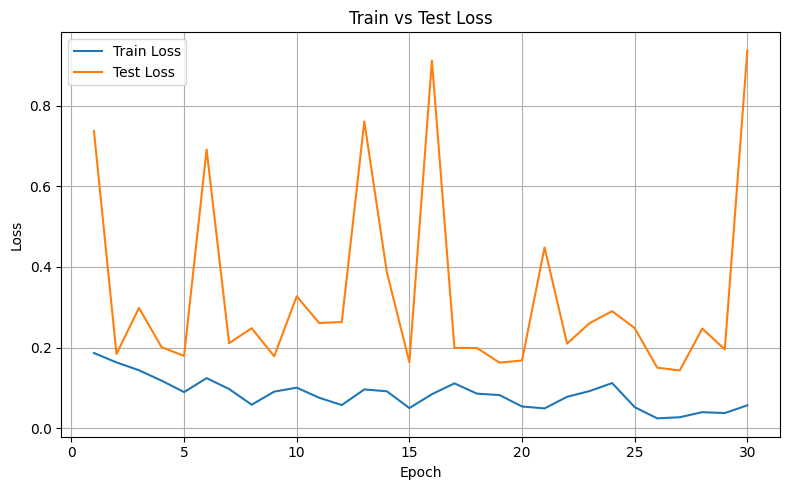

In [15]:
from helper.Visualize import plot_train_vs_test_loss

plot_train_vs_test_loss(results)

In [16]:
from helper.model_utils import make_prediction, save_model

correct = 0
wrong = 0
inf_time = 0

classes = train_dataset.classes
for data in train_dataset:
    prediction, conf, inf = make_prediction(resnet18, data, classes, torch.device(device))

    if prediction == classes[data[1]]:
        correct += 1
    else:
        wrong += 1
    
    inf_time +=inf

print(f"total: {correct+wrong}")
print(f"correct: {correct}")
print(f"Incorrect: {wrong}")
print(f"average inference time: {inf_time/(correct+wrong)}")

total: 1240
correct: 1117
Incorrect: 123
average inference time: 6.883791129032259


In [17]:
from helper.model_utils import save_model

data = {
    "title": "ResNet18 Lite",
    "arch": "A modified ResNet18 architecture with a custom final fully connected layer for 3-class classification.",
    "desc": "This model is based on the standard ResNet18, pretrained on ImageNet, and fine-tuned for efficient classification of pizza, steak, and sushi images. It leverages transfer learning for fast convergence and high accuracy on small datasets, making it suitable for lightweight food image recognition tasks.",
    "train accuracy": round(results["train_acc"][-1]*100, 2),
    "training images": len(train_dataset),
    "parameters": sum(p.numel() for p in resnet18.parameters())
}
loc = Path("../models")

save_model(model=resnet18, metadata=data, name="resnet18lite", loc=loc, device= torch.device(device))

model saved at ..\models\resnet18lite.pt
